# **Imports**

In [ ]:
import torchvision as tv
from torch.utils.data import DataLoader
import torch.utils.data
import random
import numpy as np
import torchvision.transforms as transforms
from numpy import linalg as la

# **Relu Layer**

In [ ]:
class Relu_t :
#Relu Layer class
    def forward(self , Layer_Input): 
        #Forward Function of Relu Z = Rel(Z)
        self.Layer_Input = Layer_Input
        self.Layer_Output = np.maximum(Layer_Input, 0)
        return self.Layer_Output
    
    def backward(self , Layer_output):
        #Backward Function of Relu
        self.Layer_Input[self.Layer_Input < 0 ] = 0
        self.Layer_Input[self.Layer_Input >= 0 ] = 1
#         print(self.Layer_Input.shape)
#         print(Layer_output.shape)
        self.dl_dz = (self.Layer_Input*Layer_output)
        return self.dl_dz
    def zero_grad(self):
        #Zero Function of Relu
        self.dl_dz = np.zeros_like(self.dl_dz)

# **SoftMaxEntropy Layer**

In [ ]:
class SoftmaxCrossEntropy_t:
#Softmax Layer class
    def forward(self ,Layer_Input,Y_Targets):
        #Forward Function of SoftMax+CrossEntropy
        #Softmax Calculation Y = Soft_Max(Z)
        Y_Pred = (np.exp(Layer_Input)/np.sum(np.exp(Layer_Input),axis=1).reshape(Y_Targets.shape[0],1))
        self.Y_Pred = Y_Pred
        self.Targets = Y_Targets
        #CrossEntropy Calculation L = cross_entropy(Y)
        crossentropy = (-1* np.log(Y_Pred)*Y_Targets)
        #Average Loss Calculation
        averageLoss = (np.sum(crossentropy)/Y_Targets.shape[0])
        return Y_Pred,averageLoss,crossentropy,
        
    def backward(self , Layer_output):
        #Backward Function of SoftMax+CrossEntropy
        self.dl_dz = self.Y_Pred - self.Targets
        return self.dl_dz
    
    def zero_grad(self):
        #Zero Function of Loss w.r.t to Activation
        self.dl_dz = np.zeros_like(self.dl_dz)

# **Linear Layer**

In [ ]:
class LinearLayer_t :
#Linear Layer class    
    def __init__ (self, num_features, num_classes):
        #Intitialization of Linear Layer
        mean = 0
        stddev = 0.1
        #Intitialization of Random weights and Bias in Gaussian space
        weights = np.random.normal(mean, stddev, size = (num_features,num_classes))
        bias = np.random.normal(mean, stddev, size = (num_classes))
        #Normalize weights and Bias making L2 norm of w,b = 1
        _wl2_norm = 1/((la.norm(weights)))
        _bl2_norm = 1/((la.norm(bias)))
        self.w = weights * _wl2_norm
        self.b = bias * _bl2_norm

    def forward(self , Layer_Input): 
        #Forward Function of Linear Layer Z = WX + B
        self.Layer_Input = Layer_Input
        self.Layer_Output = (np.dot(Layer_Input,self.w)) + self.b
        return self.Layer_Output

    def backward(self , Layer_output):
        #Backward Function of Linear layer
        #dl_dw = dl_dz * dz_dw = dl_dz * x
        #dl_db = dl_dz * dz_db = sum(dl_dz) * 1/m
        self.dl_dw = (1/self.Layer_Input.shape[0])*np.dot(self.Layer_Input.T,Layer_output)
        self.dl_db = (1/self.Layer_Input.shape[0])* np.sum(Layer_output, axis=0,keepdims = True)
        return self.dl_dw,self.dl_db
    def zero_grad(self):
        #Zerograd Function of Linear layer
        self.dl_db = np.zeros_like(self.dl_db)
        self.dl_dw = np.zeros_like(self.dl_dw)

# **Preprocess Functions**

In [ ]:
def normalize(dataset):
#Min-max normalization of the dataset
        dataset = dataset/255
#         dataset = (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))
        return dataset
    
def onehotencoding(dataset_label,num_classes):
#One Hot encoding of the class label
        shape = (dataset_label.size, num_classes)
        num_rows = np.arange(dataset_label.size)
        dataset_target_hot = np.zeros(shape)
        dataset_target_hot[num_rows, dataset_label] = 1
        return dataset_target_hot
    
def NormalizedRandomSampling(dataset,sample_size):
#Random Sample the dataset based on passed sample size
        dataset_targets = dataset.targets.numpy()
        dataset_data = dataset.data.numpy()
        dataset_data = normalize(dataset_data)        
        Full_dataset_index = np.arange(dataset.data.shape[0]) 
        Sampled_dataset_index = np.random.choice(Full_dataset_index, sample_size, replace= False)
        dataset_data = np.take(dataset_data,Sampled_dataset_index,axis=0)
        dataset_targets = np.take(dataset_targets,Sampled_dataset_index,axis=0)
        return dataset_data,dataset_targets

def datasetshuffling(dataset_data_target_Label,sample_size):
#Random Shuffle the dataset   
        Batch_dataset_index = np.arange(dataset_data_target_Label[0].shape[0])
        Sampled_dataset_index = np.random.choice(Batch_dataset_index, sample_size, replace= False)
        dataset_data_np = np.take(dataset_data_target_Label[0],Sampled_dataset_index,axis=0)
        dataset_label_np = np.take(dataset_data_target_Label[1],Sampled_dataset_index,axis=0)
        return dataset_data_np,dataset_label_np
    

def validationPhase(network,test_batch,num_features):
#Validation phase of the dataset
        Layer_output = test_batch.reshape(-1,num_features)
        Layer_output = network[0].forward(Layer_output)    
        Layer_output = network[1].forward(Layer_output)        
        y_prediction,average_loss,cross_entropy = network[2].forward(Layer_output,test_label_batch)
        return y_prediction,average_loss,cross_entropy
        

# **Dataset Preprocess**

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
num_epochs = 200
learning_rate = 0.01
num_classes = 10
num_features = 784
train50Len = 30000
val50Len = 5000


train = tv.datasets.MNIST('../data', download=True,train=True)
val = tv.datasets.MNIST('../data', download=True,train=False)

train_data,train_label = NormalizedRandomSampling(train,train50Len)
test_data,test_label = NormalizedRandomSampling(val,val50Len)

train_label = onehotencoding(train_label,num_classes)
test_label  = onehotencoding(test_label,num_classes)

train_data_target_Label = [train_data, train_label]
test_data_target_Label =  [test_data, test_label]

# **Neural Network Initializations**

In [ ]:
LL_T = LinearLayer_t(num_features,num_classes)
Rel_T = Relu_t()
SS_T = SoftmaxCrossEntropy_t()

network = [LL_T,Rel_T,SS_T]

# **Batch wise Train + Validation Process**

In [ ]:
loss = []
valloss = []
AllBatchTrainLoss = []
AllBatchValLoss = []
trainingacc = []
validationacc = []
batchtrainingacc = []
batchvalidationacc = []
#epoch iteration
for epoch in range(num_epochs):
#     train_data_np,train_label_np = datasetshuffling(train_data_target_Label,train50Len)
#     test_data_np,test_label_np = datasetshuffling(test_data_target_Label,val50Len)
    train_data_np,train_label_np = train_data_target_Label
    test_data_np,test_label_np = test_data_target_Label
    train_accuracy = 0
    test_accuracy = 0
    epochtrainloss = []
    epochtestloss = []
    print("Epoch: ",epoch+1 )
    counter = 0
    batch_idx = 0
 #Batch iteration   
    while(counter<=train_data_np.shape[0]):
        if (train_data_np.shape[0] - counter) < batch_size:
            train_batch = train_data_np[counter:]
            train_label_batch = train_label_np[counter:]
            counter = counter + batch_size

        else:
            train_batch = train_data_np[counter:counter + batch_size]
            train_label_batch = train_label_np[counter:counter + batch_size]
            counter = counter + batch_size
            
        real = train_batch.reshape(-1,num_features)
                
        Layer_output = LL_T.forward(real)    
        Layer_output = Rel_T.forward(Layer_output)        
        y_prediction,average_loss,cross_entropy = SS_T.forward(Layer_output,train_label_batch)
        
        epochtrainloss.append(average_loss)
        AllBatchTrainLoss.append(average_loss)
        acc = np.argmax(y_prediction, axis = 1)
#       print(acc)
        labels = np.argmax(train_label_batch, axis = 1)
        train_accuracy += np.count_nonzero(acc == labels)
        batchtrainingacc.append((np.count_nonzero(acc == labels)/batch_size) * 100)
        
        grad_output1 = SS_T.backward(cross_entropy)
        grad_output2 = Rel_T.backward(grad_output1)
        grad_output3 = LL_T.backward(grad_output2)
               
        
        batch_idx = batch_idx + 1

        LL_T.w = LL_T.w - learning_rate*LL_T.dl_dw
        LL_T.b = LL_T.b - learning_rate*LL_T.dl_db
        
        for layer in network:
            layer.zero_grad()

    trainingacc.append((train_accuracy/counter)*100)
    loss.append(np.mean(epochtrainloss))       
    print("Training Accuracy: ",(train_accuracy/counter)*100)
    
#Validation phase of the dataset for each epoch    
    testcounter = 0
    testbatch_idx = 0
    #Batchwise iteration
    while(testcounter<=test_data_np.shape[0]):
        if (test_data_np.shape[0] - testcounter) < batch_size:
            test_batch = test_data_np[testcounter:]
            test_label_batch = test_label_np[testcounter:]
            testcounter = testcounter + batch_size
        else:
            test_batch = test_data_np[testcounter:testcounter + batch_size]
            test_label_batch = test_label_np[testcounter:testcounter + batch_size]
            testcounter = testcounter + batch_size
        y_prediction,average_loss,cross_entropy = validationPhase(network,test_batch,num_features)
        acc = np.argmax(y_prediction, axis = 1)
        epochtestloss.append(average_loss)
        AllBatchValLoss.append(average_loss)
        labels = np.argmax(test_label_batch, axis = 1)
        test_accuracy += np.count_nonzero(acc == labels)   
        batchvalidationacc.append((np.count_nonzero(acc == labels)/batch_size) * 100)
        
    validationacc.append((test_accuracy/testcounter)*100)
    valloss.append(np.mean(epochtestloss))        
    print("Testing Accuracy: ",((test_accuracy/testcounter)*100))

Epoch:  1
Training Accuracy:  80.41044776119402
Testing Accuracy:  86.5047770700637
Epoch:  2
Training Accuracy:  87.04357675906184
Testing Accuracy:  87.9578025477707
Epoch:  3
Training Accuracy:  88.18630063965884
Testing Accuracy:  88.89331210191082
Epoch:  4
Training Accuracy:  88.76932302771856
Testing Accuracy:  89.45063694267516
Epoch:  5
Training Accuracy:  89.23240938166312
Testing Accuracy:  89.88853503184714
Epoch:  6
Training Accuracy:  89.61553837953092
Testing Accuracy:  90.10748407643312
Epoch:  7
Training Accuracy:  89.8320895522388
Testing Accuracy:  90.1671974522293
Epoch:  8
Training Accuracy:  90.09861407249467
Testing Accuracy:  90.34633757961782
Epoch:  9
Training Accuracy:  90.29850746268657
Testing Accuracy:  90.48566878980891
Epoch:  10
Training Accuracy:  90.39179104477611
Testing Accuracy:  90.68471337579618
Epoch:  11
Training Accuracy:  90.50839552238806
Testing Accuracy:  90.80414012738854
Epoch:  12
Training Accuracy:  90.65165245202559
Testing Accuracy: 

# **Training/Validation Epochwise Loss:**

Text(0, 0.5, 'Loss')

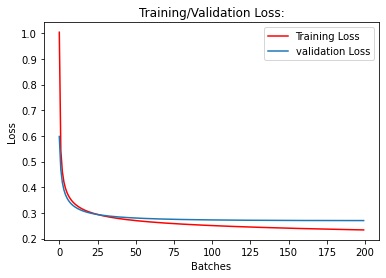

In [ ]:
import matplotlib.pyplot as plt
plt.title("Training/Validation Loss:")
plt.plot(loss,color = 'r', label="Training Loss")
plt.plot(valloss,label="validation Loss")
leg = plt.legend(loc='upper right')
plt.xlabel("Batches")
plt.ylabel("Loss")

# **Training/Validation Batchwise Loss:**

Text(0, 0.5, 'Loss')

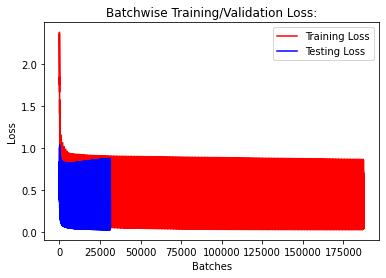

In [ ]:
import matplotlib.pyplot as plt
plt.title("Batchwise Training/Validation Loss:")
plt.plot(AllBatchTrainLoss,color = 'r', label="Training Loss")
plt.plot(AllBatchValLoss,color = 'b', label="Testing Loss")
leg = plt.legend(loc='upper right')
plt.xlabel("Batches")
plt.ylabel("Loss")

# **Training/Validation Batchwise Accuracy:**

Text(0, 0.5, 'Accuracy%')

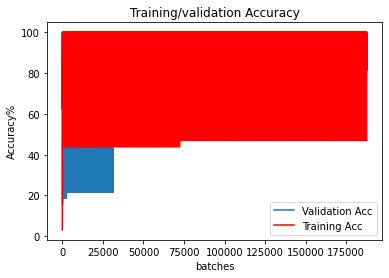

In [ ]:
plt.title("Training/validation Accuracy")
plt.plot(batchvalidationacc,label="Validation Acc")
plt.plot(batchtrainingacc,color = 'r',label="Training Acc")
leg = plt.legend(loc='lower right')
plt.xlabel("batches")
plt.ylabel("Accuracy%")

# **Training/Validation Batchwise Error:**

Text(0, 0.5, 'Error%')

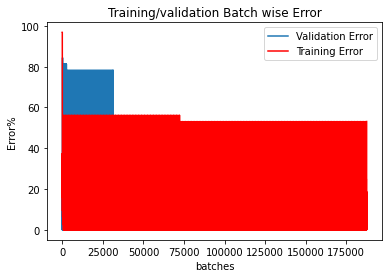

In [ ]:
plt.title("Training/validation Batch wise Error")

plt.plot(100-np.array(batchvalidationacc),label="Validation Error")
plt.plot(100-np.array(batchtrainingacc),color = 'r',label="Training Error")
leg = plt.legend(loc='upper right')
plt.xlabel("batches")
plt.ylabel("Error%")

# **Training/Validation Epochwise Error:**

Text(0, 0.5, 'Training Error%')

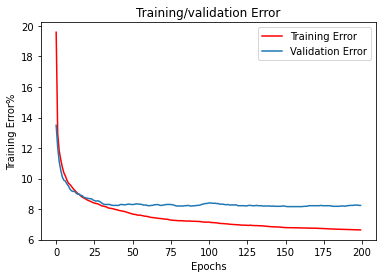

In [ ]:
plt.title("Training/validation Error")
plt.plot(100-np.array(trainingacc),color = 'r',label="Training Error")
plt.plot(100-np.array(validationacc),label="Validation Error")
leg = plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Training Error%")

# **Training/Validation Epochwise Accuracy:**

Text(0, 0.5, 'Accuracy%')

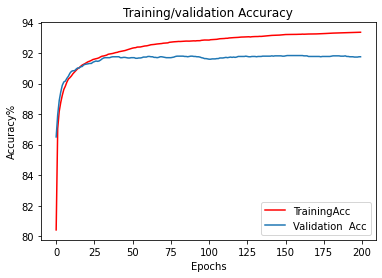

In [ ]:
plt.title("Training/validation Accuracy")
plt.plot(trainingacc,color = 'r' ,label="TrainingAcc")
plt.plot(validationacc ,label="Validation  Acc")
leg = plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy%")